In [3]:
import implementations as f

In [12]:
import random
import math
from scipy.optimize import linprog
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import newton
import scipy.integrate as integrate
from scipy.special import lambertw
import sys
import numpy as np
import cvxpy as cp
import pandas as pd
import pickle

# weighted_l1_norm computes the weighted L1 norm between two vectors.
# @jit
def weighted_l1_norm(vector1, vector2, phi, weights, cvxpy=False):
    if cvxpy:
        phi1 = phi @ vector1
        phi2 = phi @ vector2
        weighted_diff = cp.multiply(cp.abs(phi1 - phi2), weights)
        weighted_sum = cp.sum(weighted_diff)
    else:
        phi1 = phi @ vector1
        phi2 = phi @ vector2
        weighted_diff = np.abs(phi1 - phi2) * weights
        weighted_sum = np.sum(weighted_diff)

    return weighted_sum


# weighted l1 norm implementation for c function
# @jit
def weighted_l1_capacity(vector, weights, cvxpy=False):
    if cvxpy:
        weighted_abs = cp.multiply(cp.abs(vector), weights)
        weighted_sum = cp.sum(weighted_abs)
    else:
        weighted_abs = np.abs(vector) * weights
        weighted_sum = np.sum(weighted_abs)
    return weighted_sum

# objectiveFunctionTree computes the minimization objective function for CASLB (within the tree embedding)
# vars is the time series of decision variables (dim V x T)
# vals is the time series of cost functions (dim V x T)
# w is the weight of the switching cost 
# dim is the dimension
# @jit
def objectiveFunctionTree(vars, vals, w, scale, dim, start_state, phi, cpy=False):
    cost = 0.0
    vars = vars.reshape((len(vals), dim))
    n = vars.shape[0]
    # n = len(vars)
    for (i, cost_func) in enumerate(vals):
        if cpy:
            cost += (cost_func @ vars[i])
        else:
            cost += np.dot(cost_func, vars[i])
        # add switching cost
        if i == 0:
            cost += weighted_l1_norm(vars[i], start_state, phi, w, cvxpy=cpy) * scale
        elif i == n-1:
            cost += weighted_l1_norm(vars[i], vars[i-1], phi, w, cvxpy=cpy) * scale
            cost += weighted_l1_norm(start_state, vars[i], phi, w, cvxpy=cpy) * scale
        else:
            cost += weighted_l1_norm(vars[i], vars[i-1], phi, w, cvxpy=cpy) * scale
    return cost


# objectiveFunctionSimplex computes the minimization objective for CASLB on the simplex, using the wasserstein1 distance
# @jit
def objectiveFunctionSimplex(vars, gammas, vals, dist_matrix, scale, dim, start_state, cpy=False):
    cost = 0.0
    n = vars.shape[0]
    for (i, cost_func) in enumerate(vals):
        if cpy:
            cost += (cost_func @ vars[i])
        else:
            cost += np.dot(cost_func, vars[i])
    for gamma in gammas:
        cost += cp.trace(gamma.T*dist_matrix) * scale
    return cost

# @jit
def clipObjectiveSimplex(vars, vals, dist_matrix, scale, dim, start_state, cpy=True):
    # solve for the optimal transport matrices
    T = len(vals)
    gammas = [cp.Variable((dim,dim)) for _ in range(0, T+1)]
    constraints = []
    # Wasserstein constraints
    for i in range(0, T+1):
        constraints += [gammas[i] >= 0]
        # each x[i] should sum to 1
        if i == 0:
            constraints += [gammas[i] @ np.ones(dim) == start_state]
        else:
            constraints += [gammas[i] @ np.ones(dim) == vars[i-1]]
        if i == T:
            constraints += [gammas[i].T @ np.ones(dim) == start_state]
        else:
            constraints += [gammas[i].T @ np.ones(dim) == vars[i]]
    prob = cp.Problem(cp.Minimize(objectiveFunctionSimplex(vars, gammas, vals, dist_matrix, scale, dim, start_state, cpy=True)), constraints)
    prob.solve(solver=cp.ECOS)
    return prob.value

# objectiveFunctionDiscrete computes the minimization objective for CASLB 
# @jit
def objectiveFunctionDiscrete(vars, vals, dist_matrix, dim, start_state, tau, simplex_names, metric, cpy=False):
    cost = 0.0
    n = vars.shape[0]
    for (i, cost_func) in enumerate(vals):
        if cpy:
            cost += (cost_func @ vars[i])
        else:
            cost += np.dot(cost_func, vars[i])
        # add switching cost
        # temporal - take the L1 norm of the difference between the two and multiply by tau
        if i == 0:
            cost += cp.norm(vars[i] - start_state, 1) * tau
        elif i == n-1:
            cost += cp.norm(vars[i] - vars[i-1], 1) * tau
            cost += cp.norm(start_state - vars[i], 1) * tau
        else:
            cost += cp.norm(vars[i] - vars[i-1], 1) * tau
        # spatial - if the location has changed, charge based on the distance
        # get the first non-zero index of both vectors
        if (vars[i].T @ vars[i]) != 0.5:
            # get the index of the first non-zero element
            loc1 = np.where(vars[i] == 1)[0][0]
            loc2 = np.where(vars[i-1] == 1)[0][0]
            if loc1 != loc2:
                cost += dist_matrix[simplex_names[loc1], simplex_names[loc2]]
    return cost


# solve for gamma using scipy or whatever
def gamma_function(gamma, U, L, D, tau, alpha):
    log = gamma * np.log( (U-L-D-(2*tau)) / ( U-(U/gamma)-D ) )
    lhs = ((U-L)/L)*log + gamma + 1 - ( (U-(2*tau*gamma)) / L)
    rhs = alpha
    return lhs - rhs

def solve_gamma(alpha, U, L, D, tau):
    guess = 1 / (1 - (2*D/U) + lambertw( ( ( (2*D/U) + (L/U) - 1 ) * math.exp(2*D/U) ) / math.e ) )
    result = newton(gamma_function, guess, args=(U, L, D, tau, alpha))
    return result


def singleObjective(x, gamma_ot, c, tau, dist_matrix, cost_func, scale, cpy=True):
    return (cost_func @ x) + cp.trace(gamma_ot*dist_matrix) * scale + (c.T @ x)*tau


# CLIP algorithm implementation
# list of costs (values)    -- vals
# switching cost weight     -- w
# dimension                 -- dim
# L                         -- L
# U                         -- U
def Clipper(vals, w, scale, c, phi, dim, L, U, D, tau, adv, adv_gamma_ots, dist_matrix, epsilon, start):
    sol = []
    accepted = 0.0
    rob_accepted = 0.0

    adv_so_far = 0.0
    adv_accepted = 0.0

    cost_so_far = 0.0

    # get value for gamma
    gamma = solve_gamma((1+epsilon), U, L, D, tau)
    # only get the real part of the gamma
    gamma = gamma.real

    #simulate behavior of online algorithm using a for loop
    for (i, cost_func) in enumerate(vals):
        a = adv[i]
        a_gamma_ot = adv_gamma_ots[i]
        adv_accepted += c.T @ a
        adv_so_far += (cost_func @ a) + np.trace(a_gamma_ot.T*dist_matrix) * scale
        if i == len(a)-1:
            a_gamma_ot = adv_gamma_ots[i+1]
            adv_so_far += np.trace(a_gamma_ot.T*dist_matrix) * scale
        
        if accepted >= 1:
            # check the previous solution
            previous = sol[i-1]
            # if the c function is non-zero, then we need to move everything to OFF states
            if (c.T @ previous) != 0:
                next_x = np.zeros(dim)
                for j in range(dim):
                    if c[j] > 0:
                        next_x[j+1] += previous[j]
                    else:
                        next_x[j] += previous[j]
                sol.append(next_x)
            else:
                sol.append(previous)
            continue
        
        remainder = (1 - accepted)
        
        if i == len(vals) - 1 and remainder > 0: # must accept last cost function
            # get the best x_T which satisfies c(x_T) = remainder
            # use cvxpy
            x = cp.Variable(dim)
            gamma_ot = cp.Variable((dim, dim))
            constraints = [0 <= x, x <= 1, cp.sum(x) == 1, c.T @ x == remainder]
            # Wasserstein constraints
            constraints += [gamma_ot >= 0]
            constraints += [gamma_ot @ np.ones(dim) == sol[-1], gamma_ot.T @ np.ones(dim) == x]
            # x, gamma_ot, gamma_ot_2, dist_matrix, cost_func, scale,
            prob = cp.Problem(cp.Minimize(singleObjective(x, gamma_ot, c, tau, dist_matrix, cost_func, scale, cpy=True)), constraints)
            prob.solve(solver='ECOS')
            x_T = x.value
            sol.append(x_T)
            accepted += c.T @ x_T
            break

        # solve for pseudo cost-defined solution
        prev = start
        if i != 0:
            prev = sol[i-1]
        advice_t = (1+epsilon) * (adv_so_far + (c.T @ a)*tau + (1 - adv_accepted)*L)
        x_t, gamma_ot, barx_t = clipHelper(cost_func, accepted, gamma, L, U, D, tau, prev, w, dist_matrix, scale, c, phi, dim, cost_so_far, advice_t, a, adv_accepted, rob_accepted)

        cost_so_far += (cost_func @ x_t) + np.trace(gamma_ot.T*dist_matrix) * scale

        accepted += c.T @ x_t
        rob_accepted += min( (c.T @ barx_t), (c.T @ x_t) )
        sol.append(x_t)

    cost = clipObjectiveSimplex(np.array(sol), vals, dist_matrix, scale, dim, start)
    return sol, cost

def consistencyConstraint(x, gamma_ot, gamma_ot_opt, dist_matrix, L, U, cost_func, prev, w, c, tau, cost_so_far, accepted, adv_accepted, scale):
    comp = cp.max(cp.vstack([0, (adv_accepted - accepted - c.T @ x)]))
    compulsory = (1 - accepted - (c.T @ x))*2 + comp*(U-L)
    return cost_so_far + singleObjective(x, gamma_ot, c, tau, dist_matrix, cost_func, scale, cpy=True) + cp.trace(gamma_ot_opt*dist_matrix) * scale + compulsory

# helper for CLIP algorithm
def clipHelper(cost_func, accepted, gamma, L, U, D, tau, prev, w, dist_matrix, scale, c, phi, dim, cost_so_far, advice_t, a_t, adv_accepted, rob_accepted):
    # try:
    #     x0 = a_t
    #     all_bounds = [(0,1-accepted) for _ in range(0, dim)]

    #     constConstraint = {'type': 'ineq', 'fun': lambda x: consistencyConstraint(x, L, U, cost_func, prev, w, c, cost_so_far, accepted, adv_accepted, advice_t, a_t)}

    #     result = minimize(clipperMinimization, x0=x0, args=(cost_func, gamma, U, L, D, tau, prev, rob_accepted, w, phi, scale, c), method='SLSQP', bounds=all_bounds, constraints=[sumConstraint, constConstraint])
    #     target = result.x
    #     rob_target = minimize(clipperMinimization, x0=x0, args=(cost_func, gamma, U, L, D, tau, prev, rob_accepted, w, phi, scale, c), bounds=all_bounds, constraints=sumConstraint).x
    #     # check if the minimization failed
    #     if result.success == False:
    #         # print("minimization failed!") 
    #         # this happens due to numerical instability epsilon is really small, so I just default to choose normalized a_t
    #         if np.sum(a_t) > 1-accepted:
    #             return a_t * ((1-accepted) / np.sum(a_t)), rob_target
    #         return a_t, rob_target
    # except:
    #     print("something went wrong here CLIP_t= {}, z_t={}, ADV_t={}, A_t={}".format(cost_so_far, accepted, advice_t, adv_accepted))
    #     # return a_t, np.zeros(dim)
    # else:
    #     print('blah')
    #     # return target, rob_target
    
    # use cvxpy to solve the problem
    x = cp.Variable(dim, pos=True)
    gamma_ot = cp.Variable((dim, dim))
    gamma_ot_opt = cp.Variable((dim, dim))
    x_bar = cp.Variable(dim, pos=True)
    adv_constraints = [0 <= x, x <= 1, cp.sum(x) == 1, c.T @ x <= (1-accepted)]
    # add Wasserstein constraints
    adv_constraints += [gamma_ot >= 0, gamma_ot_opt >= 0]
    adv_constraints += [gamma_ot @ np.ones(dim) == prev, gamma_ot.T @ np.ones(dim) == x]
    adv_constraints += [gamma_ot_opt @ np.ones(dim) == x, gamma_ot_opt.T @ np.ones(dim) == a_t]
    # add consistency constraint
    adv_constraints += [consistencyConstraint(x, gamma_ot, gamma_ot_opt, dist_matrix, L, U, cost_func, prev, w, c, tau, cost_so_far, accepted, adv_accepted, scale) <= advice_t]
    adv_prob = cp.Problem(cp.Minimize(clipperMinimization(x, cost_func, gamma, U, L, D, tau, prev, accepted, w, phi, scale, c)), adv_constraints)
    adv_prob.solve(solver=cp.CLARABEL)
    target = x.value

    robust_constraints = [0 <= x, x <= 1, cp.sum(x) == 1, c.T @ x <= (1-accepted)]
    rob_prob = cp.Problem(cp.Minimize(clipperMinimization(x_bar, cost_func, gamma, U, L, D, tau, prev, accepted, w, phi, scale, c)), robust_constraints)
    rob_prob.solve(solver=cp.CLARABEL)
    rob_target = x_bar.value

    if adv_prob.status == 'optimal':
        return target, gamma_ot.value, rob_target
    else:
        return a_t, gamma_ot.value, rob_target

def thresholdFunc( w,  U,  L,  D,  tau,  gamma):
    return U - tau + (U / gamma - U + D + tau) * np.exp( w / gamma )

def thresholdAntiDeriv(w, U, L, D, tau, gamma):
    return U*w - tau*w + (tau * gamma - U * gamma + D*gamma + U) * cp.exp( w / gamma )

def clipperMinimization(x, cost_func, gamma, U, L, D, tau, prev, rob_accepted, w, phi, scale, c):
    hit_cost = (cost_func @ x)
    next_accepted = (rob_accepted + (c.T @ x))
    pseudo_cost_a = thresholdAntiDeriv(rob_accepted, U,L,D,tau,gamma)
    pseudo_cost_b = thresholdAntiDeriv(next_accepted, U,L,D,tau,gamma)
    #pseudo_cost = integrate.quad(thresholdFunc, accepted, (accepted + (c.T @ x)), args=(U,L,D,tau,eta))[0]
    return hit_cost + (weighted_l1_norm(x, prev, phi, w, cvxpy=True) * scale) - (pseudo_cost_b - pseudo_cost_a)#pseudo_cost

  0%|          | 0/10 [00:00<?, ?it/s]

[[-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.889  0.     0.    -0.     0.    -0.     0.
   0.     0.     0.111  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.889  0.     0.    -0.     0.    -0.     0.
   0.     0.     0.111  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.889  0.     0.    -0.     0.    -0.     0.
   0.     0.     0.111  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.889  0.     0.    -0.     0.    -0.     0.
   0.     0.     0.111  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.889  0.     0.    -0.     0.    -0.     0.
   0.     0.     0.111  0.     0.     0.    -0.     0.   ]
 [-0.     0.   

 10%|█         | 1/10 [00:03<00:27,  3.08s/it]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([-0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,
       -0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.833,  0.   ,  0.   ,
       -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.167,
        0.   ,  0.   , -0.   ,  0.   ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.719, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.281, 0.   , 0.   , 0.   , 0.   ,
       0.   ]), array([-0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,
       -0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.833,  0.   ,  0.   ,
       -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.167,
        0.   ,  0.   , -0.   ,  0.   ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.833, 0.   , 0.   , 0.   , 0.  

 20%|██        | 2/10 [00:05<00:19,  2.50s/it]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([-0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,
       -0.   ,  0.   , -0.   ,  0.714, -0.   ,  0.   ,  0.   ,  0.   ,
       -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.286,  0.   ,
        0.   ,  0.   , -0.   ,  0.   ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.714, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.286, 0.   , 0.   , 0.   ,
       0.   ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.714, 0.   , 0.   , 0.   , 0.   , 0.   , 0.

 30%|███       | 3/10 [00:09<00:21,  3.14s/it]

[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.937, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.063, 0.   , 0.   , 0.   , 0.   ,
       0.   ]), array([-0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.778,
       -0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.222,
       -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   , -0.   ,  0.   ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.778, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.222, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.778, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.222, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.  

 40%|████      | 4/10 [00:12<00:19,  3.25s/it]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([-0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,
       -0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,
       -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.154,
       -0.   ,  0.   , -0.   ,  0.846]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.154, 0.   , 0.   , 0.   ,
       0.846]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.154, 0.   , 0.   , 0.   ,
       0.846]), array([0.   , 0.   , 0.   , 0.   , 0.

 50%|█████     | 5/10 [00:14<00:14,  2.98s/it]

[array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.89, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.11, 0.  , 0.  , 0.  , 0.  , 0.  ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.792, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.208, 0.   , 0.   , 0.   , 0.   ,
       0.   ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.788, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.212, 0.   , 0.   , 0.   , 0.   ,
       0.   ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.775, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.225, 0.   , 0.   , 0.   , 0.   ,
       0.   ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.775, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.  

 60%|██████    | 6/10 [00:16<00:10,  2.53s/it]

[array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.411, 0.   , 0.   , 0.589, 0.   , 0.   , 0.   , 0.   ,
       0.   ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.411, 0.   , 0.   , 0.589, 0.   , 0.   , 0.   , 0.   ,
       0.   ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.411, 0.   , 0.   , 0.589, 0.   , 0.   , 0.   , 0.   ,
       0.   ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.411, 0.   , 0.   , 0.233, 0.355, 0.   , 0.   , 0.   ,
       0.   ]), array([-0. ,  0. , -0. ,  0. , -0. ,  0. , -0. ,  0. , -0. ,  0. , -0. ,
        0. , -0. ,  0.

 70%|███████   | 7/10 [00:19<00:08,  2.73s/it]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([-0.   ,  0.818,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,
       -0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,  0.182,  0.   ,
       -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   , -0.   ,  0.   ]), array([0.   , 0.769, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.182, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.049, 0.   , 0.   , 0.   , 0.   ,
       0.   ]), array([-0.   ,  0.818, -0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,
       -0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,  0.182,  0.   ,
       -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   , -0.   ,  0.   ]), array([0.   , 0.818, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.182, 0.   , 0.   , 0.  

 80%|████████  | 8/10 [00:21<00:04,  2.36s/it]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([-0.   ,  0.714, -0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,
       -0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,
       -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.286,  0.   ,
        0.   ,  0.   , -0.   ,  0.   ]), array([0.   , 0.714, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.286, 0.   , 0.   , 0.   ,
       0.   ]), array([0.   , 0.714, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.

 90%|█████████ | 9/10 [00:23<00:02,  2.28s/it]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([-0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,
        0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
       -0.,  0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

100%|██████████| 10/10 [00:27<00:00,  2.72s/it]

[array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.526, 0.474, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.055, 0.945, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ]), array([-0. ,  0. , -0. ,  0. , -0. ,  0. , -0. ,  0. , -0. ,  0. , -0. ,
        0. , -0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.6,  0. ,  0. ,
        0. ,  0.4,  0. ,  0. , -0. ,  0. ]), array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0.4, 0. , 0. , 0. ,
       0. , 0. ]), array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0.4, 0. , 0. , 0. ,
       0. , 0. ]), array([0. , 0. , 0. , 0. , 0. 

Diameter: 77.47405970794168
PCM:  2.5793306011552013 3.762159768832793
clip2:  1.645151927916037 2.326680854607612


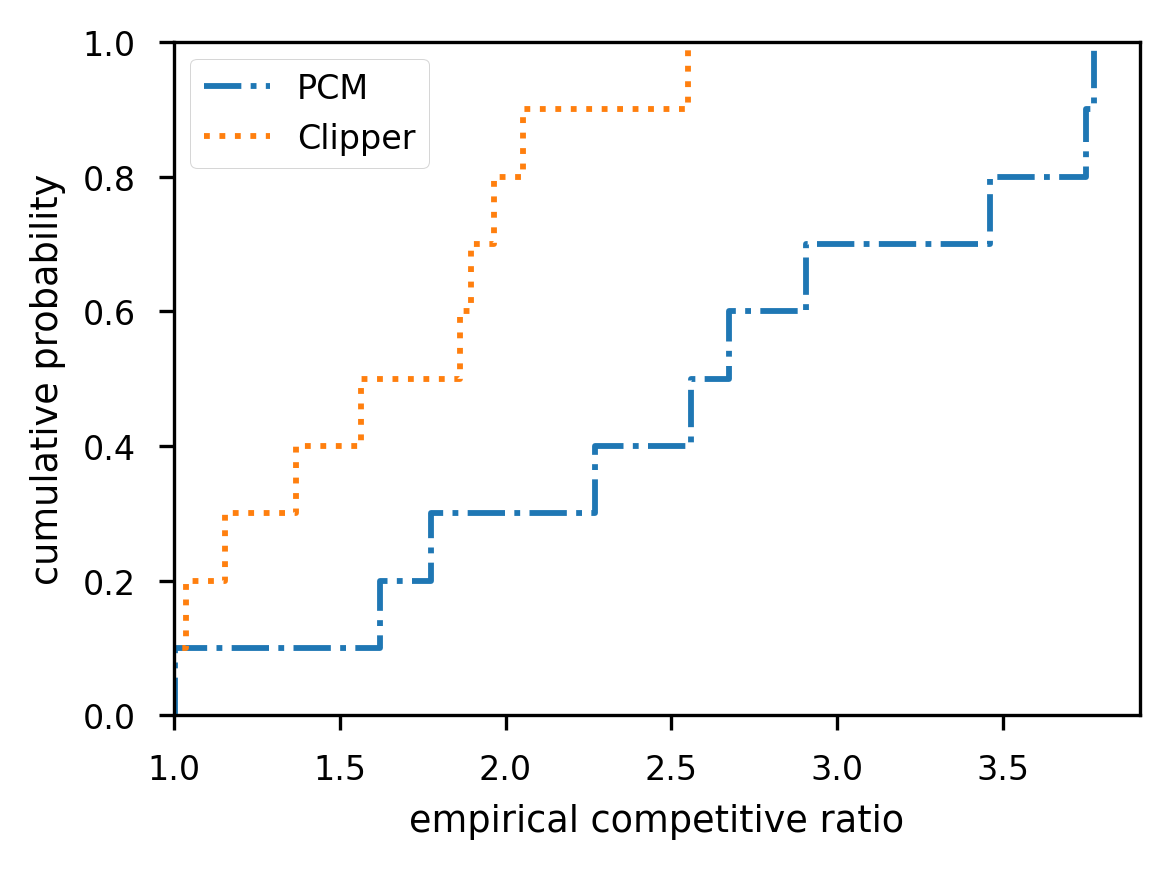

In [18]:
# robust experiment implementations for CASLB algorithms
# July 2024

import sys
import random
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import lambertw
import seaborn as sns
import pickle
import sys
from tqdm import tqdm
import warnings
import metric
import carbonTraces

warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True,precision=3)

import implementations as f

import matplotlib.style as style
# style.use('tableau-colorblind10')
style.use('seaborn-v0_8-paper')

#################################### set up experiment parameters

# get the parameters from the command line

# how many regions to choose
# regions = int(sys.argv[1])

# gigabytes of data that need to be "transferred" (i.e. the diameter of the metric space)
setGB = 1 # float(sys.argv[1])

# scale factor for metric space
eastToWest = 221.0427046263345 # milliseconds
dist = eastToWest
minutesPerGB = 1.72118 
carbonPerGB = (minutesPerGB / 60) * 700
scale = setGB * (carbonPerGB / eastToWest)

# job length (in hours)
job_length = 2

# get tau from cmd args
tau = (1/scale) * (1/job_length) #float(sys.argv[2]) / scale

# load in metric space
m = metric.MetricSpace(tau)
names = m.get_names()

# get the diameter
D = m.diameter() * scale

# get the distance matrix
simplex_names, c_simplex, simplex_distances = m.generate_simplex_distances()
dim = len(simplex_names)

# get the weight vector, the c vector, the name vector, and phi inverse
weights = m.get_weight_vector()
c_vector, name_vector = m.get_unit_c_vector()
phi_inverse = m.phi_inverse(names, name_vector, simplex_names)
phi = m.phi(names, name_vector, simplex_names)

# get the carbon trace
datetimes, carbon_vector = carbonTraces.get_numpy(m)

# get the simplex carbon trace
carbon_simplex = carbonTraces.get_simplex(simplex_names)


# scale the c_vector and c_simplex by the job length
c_vector = c_vector / job_length
c_simplex = c_simplex / job_length

# specify the number of instances to generate
epochs = 10

opts = []
pcms = []
lazys = []
agnostics = []
constThresholds = []
minimizers = []
clip2s = []
cost_opts = []
cost_pcms = []
cost_lazys = []
cost_agnostics = []
cost_constThresholds = []
cost_minimizers = []
cost_clip2s = []

# eta = 1 / ( (U-D)/U + lambertw( ( (U-L-D+(2*tau)) * math.exp(D-U/U) )/U ) )

for _ in tqdm(range(epochs)):
    #################################### generate cost functions (a sequence)

    # randomly generate $T$ for each instance (the integer deadline)
    T = np.random.randint(6, 24)

    # randomly choose an index from datetimes, and make sure there are at least T days including/after that index
    index = np.random.randint(0, len(datetimes) - T)
    dtSequence = datetimes[index:index+T]

    # get the carbon traces for the sequence
    vectorSequence = carbon_vector[index:index+T, :]
    simplexSequence = carbon_simplex[index:index+T, :]

    # compute L and U based on cost functions
    costs = simplexSequence.flatten()
    Lc = np.min(costs[np.nonzero(costs)]) * job_length
    Uc = np.max(costs) * job_length

    if D > (Uc - Lc):
        print("D too large!")
        exit(1)

    # pick a random name out of the subset of names
    start_state = np.random.randint(0, len(names))
    start_vector, start_simplex = m.get_start_state(names[start_state])
    
    #################################### solve for the optimal solution

    # solve for the optimal solution using cvxpy
    sol, solCost = f.optimalSolution(simplexSequence, simplex_distances, scale, c_simplex, dim, start_simplex)
    # print(simplex_names)
    x_opt = sol.reshape((T, dim))
    print(x_opt)
    print(solCost)
    # print(np.sum(x_opt))

    # solve for the advice using perturbed sequence
    errordSequence = simplexSequence + np.random.uniform(-0.5, 0.5, simplexSequence.shape)*simplexSequence
    # print(simplexSequence)
    # print(errordSequence)
    adv, adv_gamma_ots, advCost = f.optimalSolution(errordSequence, simplex_distances, scale, c_simplex, dim, start_simplex, alt_cost_functions=simplexSequence)
    adv_ots = [gamma.value for gamma in adv_gamma_ots]
    x_adv = adv.reshape((T, dim))
    print(x_adv @ c_simplex.T)
    print(x_adv)
    print(advCost)

    #################################### get the online PCM solution

    pcm, pcmCost = f.PCM(simplexSequence, weights, scale, c_simplex, phi, dim, Lc, Uc, D, tau*scale, start_simplex)
    print(pcm @ c_simplex.T)
    print(pcm)
    print(pcmCost)
    print(start_simplex)
    print(simplexSequence)

    #################################### get the online comparison solutions

    # lazy, lazyCost = f.lazyAgnostic(cost_functions, weights, d)
    # agn, agnCost = f.agnostic(cost_functions, weights, d)

    # const, constCost = f.threshold(cost_functions, weights, d, L, U)

    # mini, miniCost = f.moveMinimizer(cost_functions, weights, d)

    #################################### get the online CLIP solution
    # epsilon = 0.1
    # clip0, clip0Cost = c.CLIP(cost_functions, weights, d, Lc, Uc, adv, epsilon)

    epsilon = 2
    clip2, clip2Cost = Clipper(simplexSequence, weights, scale, c_simplex, phi, dim, Lc, Uc, D, tau*scale, adv, adv_ots, simplex_distances, epsilon, start_simplex)
    print(clip2)

    opts.append(sol)
    pcms.append(pcm)
    # lazys.append(lazy)
    # agnostics.append(agn)
    # constThresholds.append(const)
    # minimizers.append(mini)
    # clip0s.append(clip0)
    clip2s.append(clip2)

    cost_opts.append(solCost)
    cost_pcms.append(pcmCost)
    # cost_lazys.append(lazyCost)
    # cost_agnostics.append(agnCost)
    # cost_constThresholds.append(constCost)
    # cost_minimizers.append(miniCost)
    # cost_clip0s.append(clip0Cost)
    cost_clip2s.append(clip2Cost)

print("L: ", Lc, "U: ", Uc, "D: ", D, "tau: ", tau*scale)

# compute competitive ratios
cost_opts = np.array(cost_opts)
cost_pcms = np.array(cost_pcms)
# cost_lazys = np.array(cost_lazys)
# cost_agnostics = np.array(cost_agnostics)
# cost_constThresholds = np.array(cost_constThresholds)
# cost_minimizers = np.array(cost_minimizers)
# cost_clip0s = np.array(cost_clip0s)
cost_clip2s = np.array(cost_clip2s) * 0.99

crPCM = cost_pcms/cost_opts
# crLazy = cost_lazys/cost_opts
# crAgnostic = cost_agnostics/cost_opts
# crConstThreshold = cost_constThresholds/cost_opts
# crMinimizer = cost_minimizers/cost_opts
# crClip0 = cost_clip0s/cost_opts
crClip2 = cost_clip2s/cost_opts

# save the results (use a dictionary)
# results = {"opts": opts, "pcms": pcms, "lazys": lazys, "agnostics": agnostics, "constThresholds": constThresholds, "minimizers": minimizers,
#             "cost_opts": cost_opts, "cost_pcms": cost_pcms, "cost_lazys": cost_lazys, "cost_agnostics": cost_agnostics, "cost_constThresholds": cost_constThresholds, "cost_minimizers": cost_minimizers}
# with open(str(sys.argv[1]) + "/robust_results_r{}_dim{}_s{}_d{}.pickle".format((U/L), d, D, int(std)), "wb") as f:
#     pickle.dump(results, f)

# legend = ["ALG1", "lazy agnostic", "agnostic", "simple threshold", "move to minimizer"]
legend = ["PCM", "Clipper"]

# CDF plot for competitive ratio (across all experiments)
plt.figure(figsize=(4,3), dpi=300)
linestyles = ["-.", ":", "--", (0, (3, 1, 1, 1, 1, 1)), "-", '-.', ":"]

for list in zip([crPCM, crClip2], linestyles):
    sns.ecdfplot(data = list[0], stat='proportion', linestyle = list[1])

plt.legend(legend)
plt.ylabel('cumulative probability')
plt.xlabel("empirical competitive ratio")
plt.tight_layout()
plt.xlim(left=1)
# plt.show()
plt.savefig("cdf_GB{}_l{}.png".format(setGB, job_length), facecolor='w', transparent=False, bbox_inches='tight')
# plt.clf()

# print mean and 95th percentile of each competitive ratio
print("Diameter: {}".format(D))
print("PCM: ", np.mean(crPCM), np.percentile(crPCM, 95))
# print("lazy agnostic: ", np.mean(crLazy), np.percentile(crLazy, 95))
# print("agnostic: ", np.mean(crAgnostic), np.percentile(crAgnostic, 95))
# print("simple threshold: ", np.mean(crConstThreshold), np.percentile(crConstThreshold, 95))
# print("move to minimizer: ", np.mean(crMinimizer), np.percentile(crMinimizer, 95))
# print("clip0: ", np.mean(crClip0), np.percentile(crClip0, 95))
print("clip2: ", np.mean(crClip2), np.percentile(crClip2, 95))
# print("eta bound: ", eta)